# Определение жанра фильмов по постеру
В данном проекте мы создадим и обучим модель для решения задачи Multi-Label Image Classification. Для обучения будет использоваться датасет со списком фильмов начиная с 1984 года.

# Подготовка
На данном этапе импортируем нужные билиотеки, скачаем заранее очищенный и преобразованный в нужный формат датасет, а так же загрузим архив с постерами. Из-за ограничений ресурсов google collab, будем использовать только 10000 записей

In [1]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [2]:
train = pd.read_csv('dataset_ready.csv')
train = train.head(10000)
train.head()

,imdbId,Musical,Sport,Documentary,Drama,Adventure,Horror,Western,Animation,Game-Show,...,Family,Sci-Fi,Adult,Reality-TV,Talk-Show,Short,Action,Music,Thriller,War
0,114709,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,113497,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,114885,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,113041,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,113277,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [3]:
train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('./cleared_posters/' + str(train['imdbId'][i]) + '.jpg', target_size=(128, 128, 3))
    img = image.img_to_array(img)
    img = img / 255
    train_image.append(img)

100%|██████████| 10000/10000 [00:02<00:00, 4990.43it/s]


In [4]:
X = np.array(train_image)
X.shape

(10000, 128, 128, 3)

In [5]:
y = np.array(train.drop(['imdbId'],axis=1))
y.shape

(10000, 27)

# Обучение сети

На данном этапе мы разделим выборку на тренировочную и тестовую. Далее определим модуль и обучим ее

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40, test_size=0.2)

In [7]:
model = Sequential()

model.add(Input(shape=X_train[0].shape))

model.add(Conv2D(16, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.4))

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(27, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])


2025-01-20 01:11:04.595189: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-01-20 01:11:04.595219: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-01-20 01:11:04.595228: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-01-20 01:11:04.595257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-20 01:11:04.595273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)  # Адаптируем генератор к данным

early_stopping = EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max')
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_auc', mode='max')

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20


2025-01-20 01:11:05.361577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 9s 69ms/step - loss: 0.9986 - accuracy: 0.0896 - auc: 0.5614 - val_loss: 0.4348 - val_accuracy: 0.5215 - val_auc: 0.7628
Epoch 2/20
125/125 [==============================] - 8s 67ms/step - loss: 0.3889 - accuracy: 0.3496 - auc: 0.6988 - val_loss: 0.2563 - val_accuracy: 0.5215 - val_auc: 0.8015
Epoch 3/20
125/125 [==============================] - 9s 69ms/step - loss: 0.2581 - accuracy: 0.4291 - auc: 0.7905 - val_loss: 0.2407 - val_accuracy: 0.5215 - val_auc: 0.8299
Epoch 4/20
125/125 [==============================] - 9s 70ms/step - loss: 0.2391 - accuracy: 0.4470 - auc: 0.8195 - val_loss: 0.2288 - val_accuracy: 0.5215 - val_auc: 0.8386
Epoch 5/20
125/125 [==============================] - 8s 68ms/step - loss: 0.2323 - accuracy: 0.4613 - auc: 0.8298 - val_loss: 0.2273 - val_accuracy: 0.2965 - val_auc: 0.8364
Epoch 6/20
125/125 [==============================] - 9s 69ms/step - loss: 0.2288 - accuracy: 0.4610 - auc: 0.8349 - val_loss: 0.2228 - 

In [9]:
def plotLearningCurve(history,epochs):

  epochRange = range(1, epochs + 1)
  plt.plot(epochRange,history.history['auc'])
  plt.plot(epochRange,history.history['val_auc'])
  plt.title('Model AUC')
  plt.xlabel('Epoch')
  plt.ylabel('AUC')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

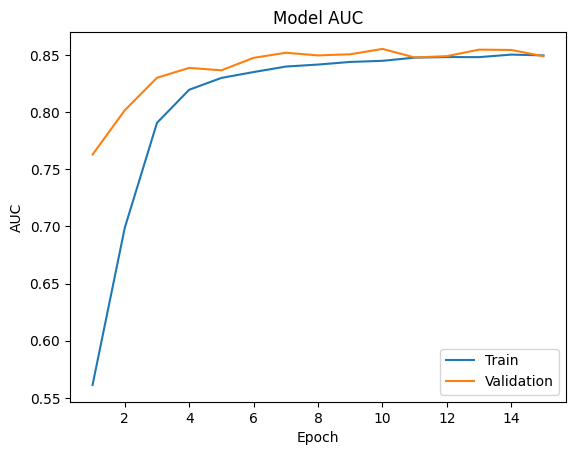

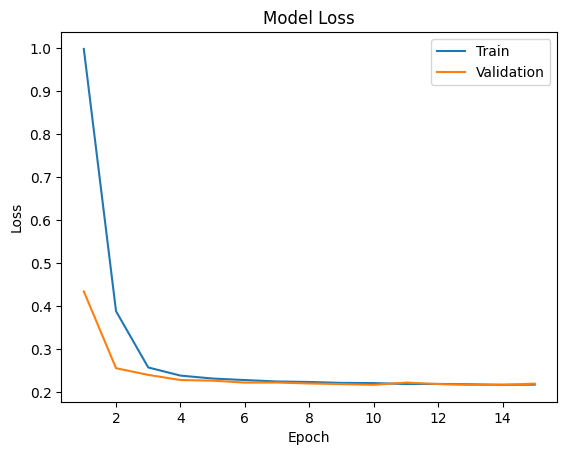

In [10]:
plotLearningCurve(history, len(history.history['accuracy']))

In [11]:
best_model = load_model('best_model.keras')


In [12]:
posters_dir = 'sample_posters'
classes = train.columns[1:]

def predict_genres(img_path, model, classes):
    img = image.load_img(img_path, target_size=(128, 128, 3))
    img_array = image.img_to_array(img) / 255.0
    img_array = img_array.reshape(1, 128, 128, 3)
    y_pred = model.predict(img_array)
    top3 = np.argsort(y_pred[0])[:-4:-1] 
    predicted_genres = [classes[i] for i in top3]
    return img, predicted_genres

1/1 [==============================] - 0s 9ms/step


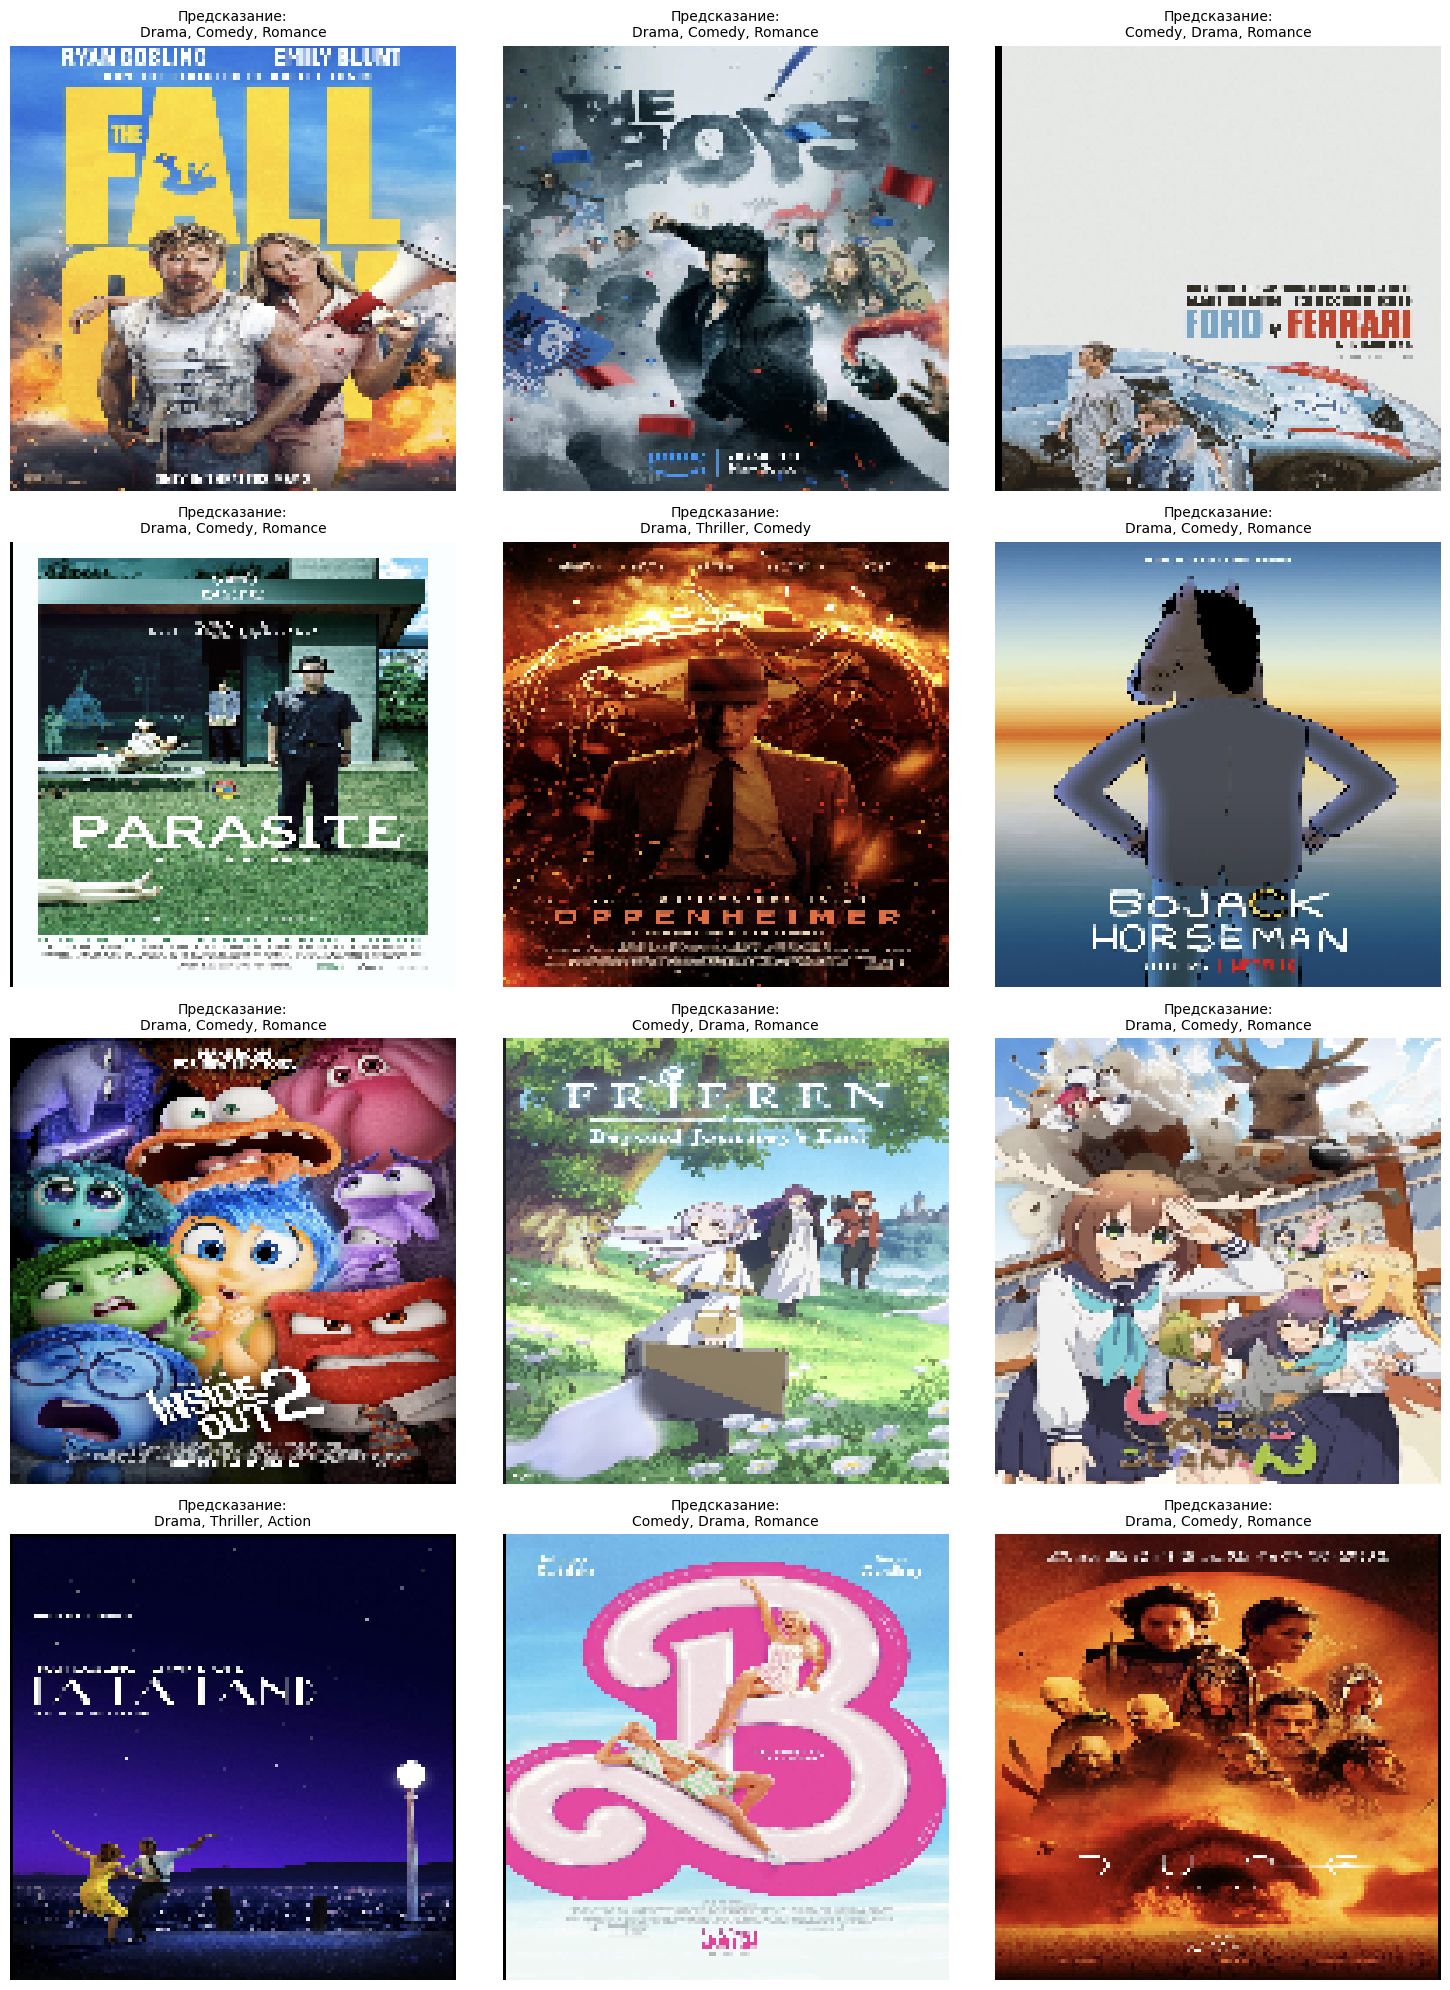

In [13]:
poster_files = [os.path.join(posters_dir, f) for f in os.listdir(posters_dir) if f.endswith(('.jpg', '.png'))]
posters_per_row = 3
fig_width = 15
num_posters = len(poster_files)
num_rows = (num_posters + posters_per_row - 1) // posters_per_row 
plt.figure(figsize=(fig_width, num_rows * 5))
for i, poster_path in enumerate(poster_files):
    img, predicted_genres = predict_genres(poster_path, best_model, classes)
    
    plt.subplot(num_rows, posters_per_row, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Предсказание:\n{', '.join(predicted_genres)}", fontsize=10)

plt.tight_layout()
plt.show()